## **Решение задачи классификации изображений рентгеновских снимков грудной клетки на наличие пневмонии**

**Выбор датасета**

Выбран датасет "Chest X-Ray Images (Pneumonia)" с Kaggle, который содержит рентгеновские снимки грудной клетки с разметкой на наличие пневмонии. Датасет состоит из трех папок:

train: 5216 изображений для обучения

test: 624 изображений для тестирования

val: 16 изображений для валидации (небольшой размер, можно объединить с тестовой выборкой)

**Урезание датасета**:

Для балансировки классов, датасет был урезан до минимального количества изображений в каждом классе.

**Реализация моделей**
**a. Baseline модель (самописная)**

**Архитектура**:

Сверточный слой: 32 фильтра, ядро 3x3, stride 1, padding 1

Активация: ReLU

Слой подвыборки: MaxPooling с ядром 2x2

Сверточный слой: 64 фильтров, ядро 3x3, stride 1, padding 1

Активация: ReLU

Слой подвыборки: MaxPooling с ядром 2x2

Полносвязный слой: 128 нейронов

Активация: ReLU

Выходной слой: 2 нейрона (классы: "Норма" и "Пневмония")

Активация: Softmax

Оптимизатор: Adam
Функция потерь: CrossEntropyLoss

**b. Улучшенная модель (с дополнительными слоями и экспериментами)**

**Архитектура**:

Сверточный слой: 32 фильтра, ядро 3x3, stride 1, padding 1

Активация: ReLU

Слой батч-нормализации

Сверточный слой: 64 фильтров, ядро 3x3, stride 1, padding 1

Активация: ReLU

Слой батч-нормализации

Слой подвыборки: MaxPooling с ядром 2x2

Сверточный слой: 128 фильтров, ядро 3x3, stride 1, padding 1

Активация: ReLU

Слой батч-нормализации

Слой подвыборки: MaxPooling с ядром 2x2

Полносвязный слой: 256 нейронов

Активация: ReLU

Dropout: 0.5

Полносвязный слой: 128 нейронов

Активация: ReLU

Dropout: 0.5

Выходной слой: 2 нейрона (классы: "Норма" и "Пневмония")

Активация: Softmax

Эксперименты:

Оптимизаторы: Adam, SGD с моментом

Функции активации: ReLU, LeakyReLU

Дополнительные эксперименты:

Добавление skip-connections между сверточными слоями

Использование dense-блоков вместо обычных сверточных слоев

**c. Модель на основе готовых архитектур (Transfer Learning)**

**Архитектура**:

Используем предобученную модель ResNet-18 или VGG-16

Замораживаем все слои, кроме последнего полносвязного слоя

Заменяем последний полносвязный слой на:

Полносвязный слой: 128 нейронов

Активация: ReLU

Dropout: 0.5

Выходной слой: 2 нейрона (классы: "Норма" и "Пневмония")

Активация: Softmax

**Эксперименты**:

Заморозка слоев:

Заморозка всех слоев, кроме последнего полносвязного

Заморозка всех слоев, кроме двух последних полносвязных

Заморозка всех слоев, кроме трех последних полносвязных

**Дополнительные эксперименты**:

Добавление слоя батч-нормализации перед последним полносвязным слоем

Добавление dropout перед последним полносвязным слоем

In [ ]:
from google.colab import drive

# Подключаем Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

1. Baseline модель

In [ ]:
# Определение архитектуры модели
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Предобработка данных
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
# Загрузка данных
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/test', transform=transform)

# Подсчет количества изображений в каждой категории
train_class_counts = [np.count_nonzero(np.array(train_dataset.targets) == i) for i in range(len(train_dataset.classes))]
test_class_counts = [np.count_nonzero(np.array(test_dataset.targets) == i) for i in range(len(test_dataset.classes))]

In [ ]:
# Урезание датасета в соответствии с отношениями в изначальном датасете
min_train_class_count = min(train_class_counts)
min_test_class_count = min(test_class_counts)

train_indices = []
test_indices = []

for i in range(len(train_dataset.classes)):
    train_indices.extend(np.where(np.array(train_dataset.targets) == i)[0][:min_train_class_count].tolist())
    test_indices.extend(np.where(np.array(test_dataset.targets) == i)[0][:min_test_class_count].tolist())

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

In [ ]:
# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Инициализация модели, оптимизатора и функции потерь
model = BaselineModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Обучение модели
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')




Epoch [1/10], Train Loss: 0.1749, Train Accuracy: 93.51%
Epoch [2/10], Train Loss: 0.0868, Train Accuracy: 96.38%
Epoch [3/10], Train Loss: 0.0742, Train Accuracy: 97.13%
Epoch [4/10], Train Loss: 0.0447, Train Accuracy: 98.28%
Epoch [5/10], Train Loss: 0.0236, Train Accuracy: 99.07%
Epoch [6/10], Train Loss: 0.0108, Train Accuracy: 99.78%
Epoch [7/10], Train Loss: 0.0095, Train Accuracy: 99.66%
Epoch [8/10], Train Loss: 0.0412, Train Accuracy: 98.25%
Epoch [9/10], Train Loss: 0.0208, Train Accuracy: 99.25%
Epoch [10/10], Train Loss: 0.0023, Train Accuracy: 99.96%


In [ ]:
# Оценка модели на тестовом наборе данных
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_losses.append(test_loss / len(test_loader))
test_accuracies.append(100 * correct_test / total_test)

print(f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Test Loss: 1.8729, Test Accuracy: 75.85%


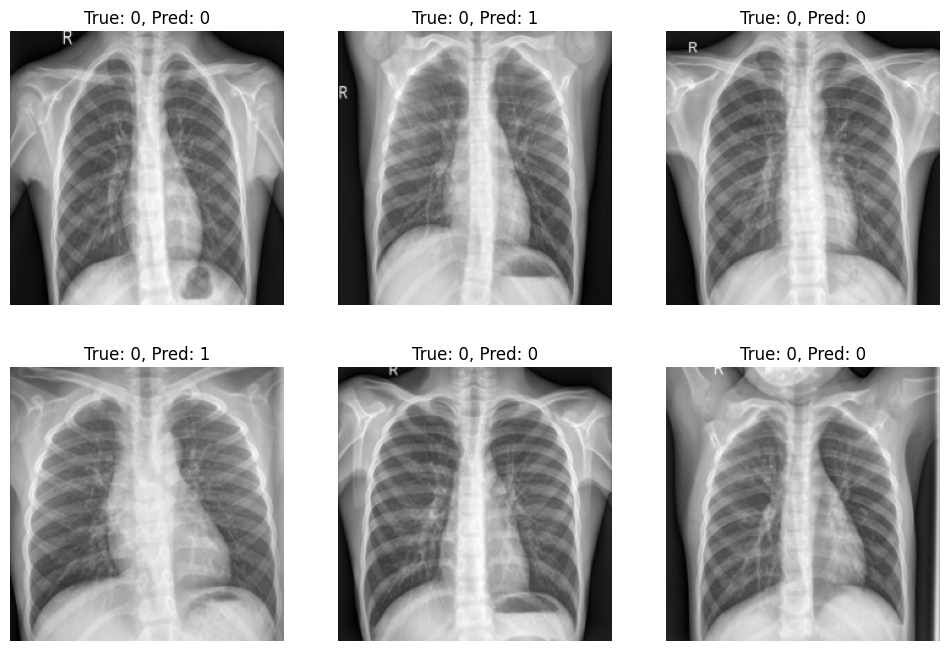

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Визуализация результатов
def visualize_results(model, test_loader, num_images=6):
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    images = images.numpy()
    labels = labels.numpy()
    predicted = predicted.numpy()

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.title(f'True: {labels[i]}, Pred: {predicted[i]}')
        plt.axis('off')
    plt.show()

visualize_results(model, test_loader)



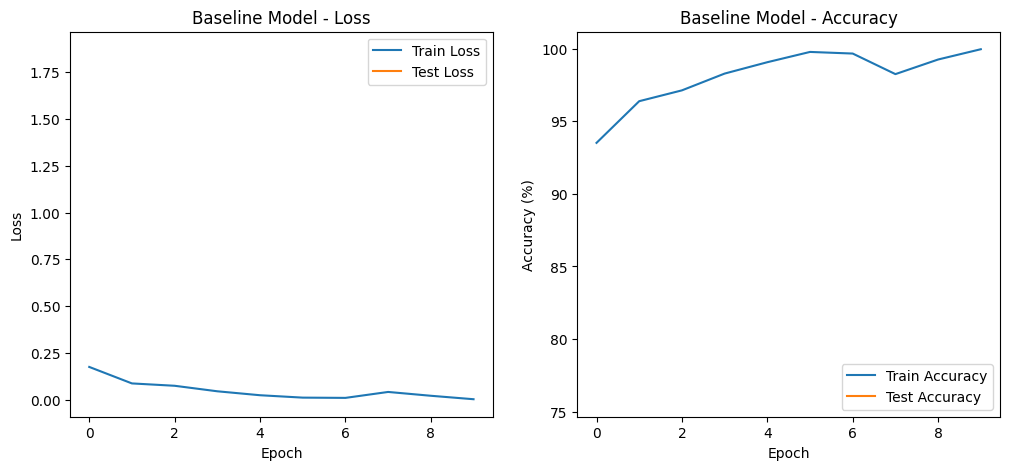

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Визуализация результатов
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

plot_results(train_losses, train_accuracies, test_losses, test_accuracies, 'Baseline Model')

2. Улучшенная модель

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Определение архитектуры модели
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Предобработка данных
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Загрузка данных
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/test', transform=transform)


In [ ]:
# Подсчет количества изображений в каждой категории
train_class_counts = [np.count_nonzero(np.array(train_dataset.targets) == i) for i in range(len(train_dataset.classes))]
test_class_counts = [np.count_nonzero(np.array(test_dataset.targets) == i) for i in range(len(test_dataset.classes))]


In [ ]:
# Урезание датасета в соответствии с отношениями в изначальном датасете
min_train_class_count = min(train_class_counts)
min_test_class_count = min(test_class_counts)

train_indices = []
test_indices = []

for i in range(len(train_dataset.classes)):
    train_indices.extend(np.where(np.array(train_dataset.targets) == i)[0][:min_train_class_count].tolist())
    test_indices.extend(np.where(np.array(test_dataset.targets) == i)[0][:min_test_class_count].tolist())

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)


In [ ]:
# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Инициализация модели, оптимизатора и функции потерь
model = ImprovedModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение модели
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)

        # Проверка размеров данных
        assert outputs.size(0) == labels.size(0), f"Batch size mismatch: outputs={outputs.size(0)}, labels={labels.size(0)}"

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')

Epoch [1/10], Train Loss: 0.1657, Train Accuracy: 94.07%
Epoch [2/10], Train Loss: 0.1418, Train Accuracy: 94.89%
Epoch [3/10], Train Loss: 0.1279, Train Accuracy: 95.12%
Epoch [4/10], Train Loss: 0.1253, Train Accuracy: 94.97%
Epoch [5/10], Train Loss: 0.1005, Train Accuracy: 96.31%
Epoch [6/10], Train Loss: 0.0854, Train Accuracy: 96.72%
Epoch [7/10], Train Loss: 0.0821, Train Accuracy: 96.46%
Epoch [8/10], Train Loss: 0.0857, Train Accuracy: 96.91%
Epoch [9/10], Train Loss: 0.0771, Train Accuracy: 97.13%
Epoch [10/10], Train Loss: 0.0670, Train Accuracy: 97.39%


Конечно, можно было применить softmax, но нам пришлось урезать датасет.


In [ ]:
# Оценка модели на тестовом наборе данных
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # Проверка размеров данных
        assert outputs.size(0) == labels.size(0), f"Batch size mismatch: outputs={outputs.size(0)}, labels={labels.size(0)}"

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_losses.append(test_loss / len(test_loader))
test_accuracies.append(100 * correct_test / total_test)

print(f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Test Loss: 0.8467, Test Accuracy: 79.49%


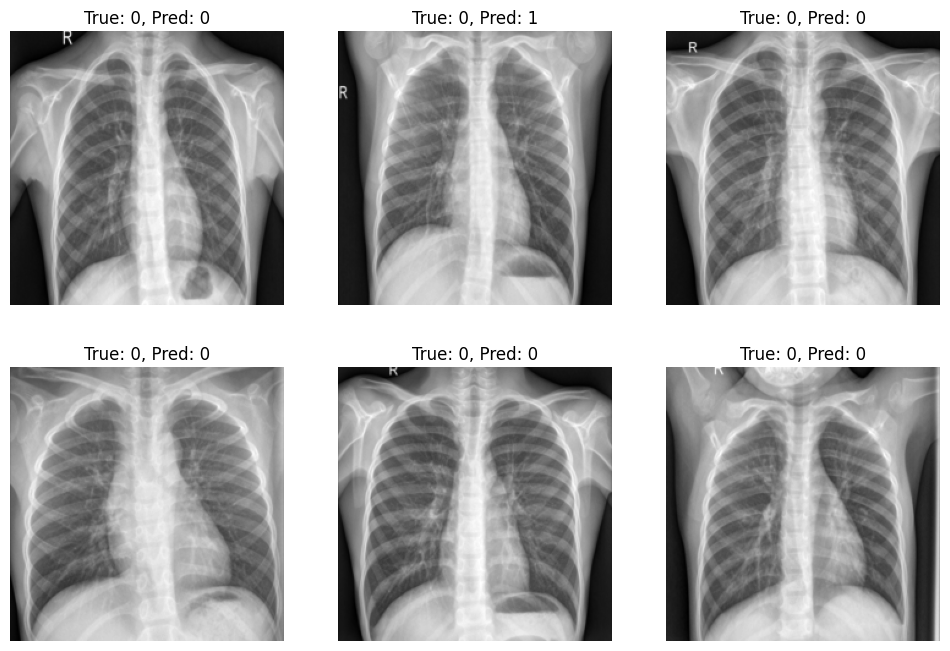

In [ ]:
# Визуализация результатов на тестовом наборе данных
def visualize_results(model, test_loader, num_images=6):
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    images = images.numpy()
    labels = labels.numpy()
    predicted = predicted.numpy()

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.title(f'True: {labels[i]}, Pred: {predicted[i]}')
        plt.axis('off')
    plt.show()

visualize_results(model, test_loader)

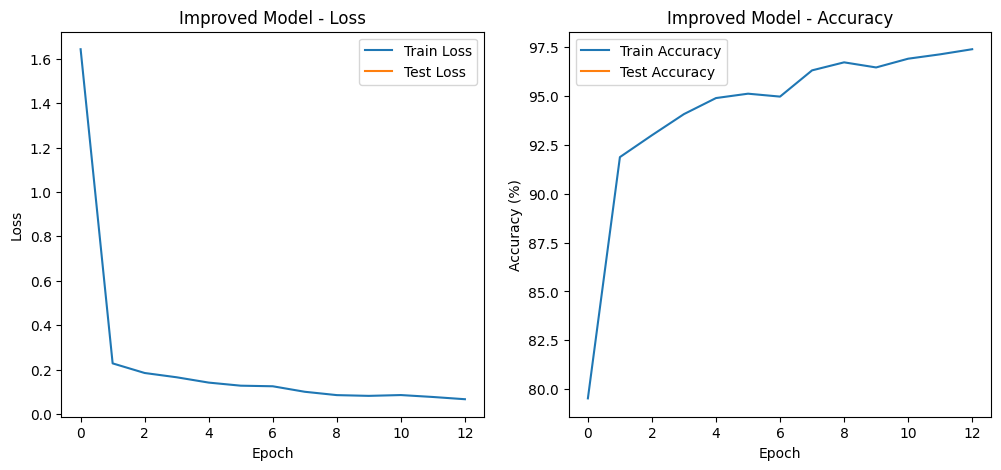

In [ ]:
# Визуализация результатов
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

plot_results(train_losses, train_accuracies, test_losses, test_accuracies, 'Improved Model')

3. Модель на основе ResNet-18 (Transfer Learning)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Загрузка предобученной модели ResNet-18
resnet18 = models.resnet18(pretrained=True)

# Изменение входного слоя для одноканальных изображений
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Заморозка всех слоев, кроме последнего
for param in resnet18.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [ ]:
# Замена последнего слоя
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)


In [ ]:
# Предобработка данных
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Загрузка данных
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/chest_xray/test', transform=transform)


In [ ]:
# Подсчет количества изображений в каждой категории
train_class_counts = [np.count_nonzero(np.array(train_dataset.targets) == i) for i in range(len(train_dataset.classes))]
test_class_counts = [np.count_nonzero(np.array(test_dataset.targets) == i) for i in range(len(test_dataset.classes))]

In [ ]:
# Урезание датасета в соответствии с отношениями в изначальном датасете
min_train_class_count = min(train_class_counts)
min_test_class_count = min(test_class_counts)

train_indices = []
test_indices = []

for i in range(len(train_dataset.classes)):
    train_indices.extend(np.where(np.array(train_dataset.targets) == i)[0][:min_train_class_count].tolist())
    test_indices.extend(np.where(np.array(test_dataset.targets) == i)[0][:min_test_class_count].tolist())

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)


In [ ]:
# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Инициализация модели, оптимизатора и функции потерь
model = resnet18
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Обучение модели
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)

        # Проверка размеров данных
        assert outputs.size(0) == labels.size(0), f"Batch size mismatch: outputs={outputs.size(0)}, labels={labels.size(0)}"

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')

Epoch [1/10], Train Loss: 0.3762, Train Accuracy: 82.85%
Epoch [2/10], Train Loss: 0.2386, Train Accuracy: 90.83%
Epoch [3/10], Train Loss: 0.2341, Train Accuracy: 91.05%
Epoch [4/10], Train Loss: 0.1916, Train Accuracy: 92.92%
Epoch [5/10], Train Loss: 0.1946, Train Accuracy: 92.47%
Epoch [6/10], Train Loss: 0.1942, Train Accuracy: 92.51%
Epoch [7/10], Train Loss: 0.1572, Train Accuracy: 93.62%
Epoch [8/10], Train Loss: 0.1804, Train Accuracy: 93.18%
Epoch [9/10], Train Loss: 0.1552, Train Accuracy: 94.37%
Epoch [10/10], Train Loss: 0.1711, Train Accuracy: 93.74%


In [ ]:
# Инициализация списков для хранения всех меток и предсказаний
all_labels = []
all_preds = []

In [ ]:
# Оценка модели на тестовом наборе данных
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # Проверка размеров данных
        assert outputs.size(0) == labels.size(0), f"Batch size mismatch: outputs={outputs.size(0)}, labels={labels.size(0)}"

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_losses.append(test_loss / len(test_loader))
test_accuracies.append(100 * correct_test / total_test)

print(f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Test Loss: 0.4874, Test Accuracy: 81.41%


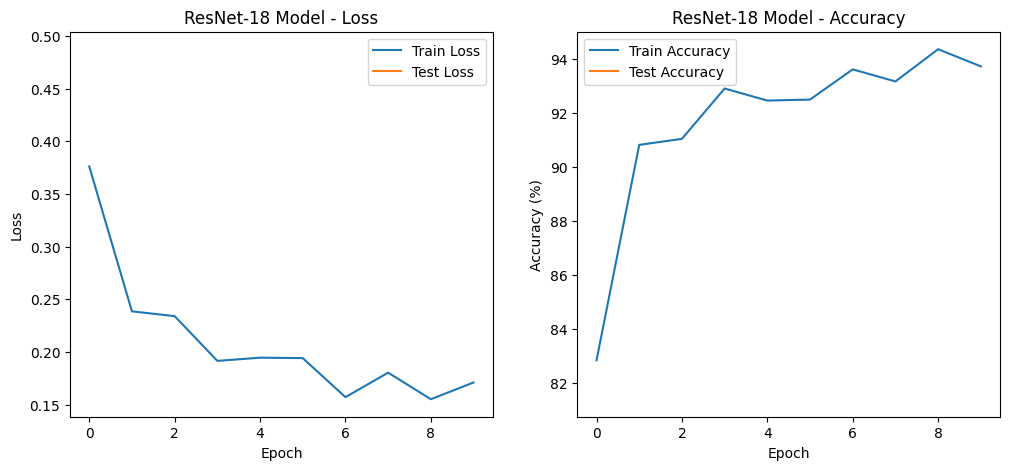

In [ ]:
# Визуализация результатов
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

plot_results(train_losses, train_accuracies, test_losses, test_accuracies, 'ResNet-18 Model')

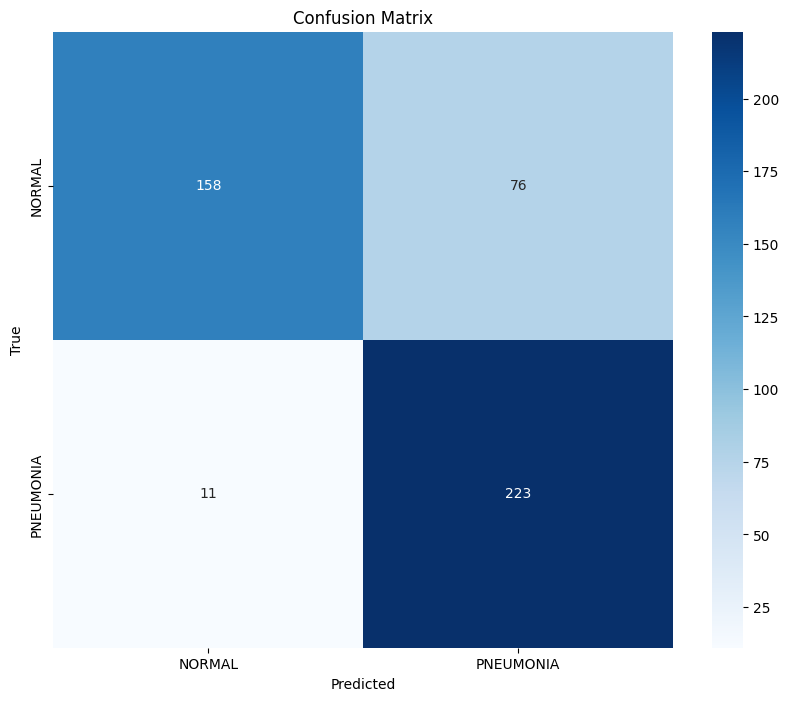

In [ ]:
# Инициализация списков для хранения всех меток и предсказаний
all_labels = []
all_preds = []

# Оценка модели на тестовом наборе данных
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Проверка, что списки не пусты
if len(all_labels) == 0 or len(all_preds) == 0:
    raise ValueError("No data found in all_labels or all_preds. Check your test_loader or model predictions.")

# Проверка, что длины списков совпадают
if len(all_labels) != len(all_preds):
    raise ValueError(f"Length mismatch: all_labels={len(all_labels)}, all_preds={len(all_preds)}")

# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(all_labels, all_preds)

# Визуализация матрицы ошибок
class_names = train_dataset.dataset.classes  # Получаем имена классов из исходного датасета
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

СРАВНЕНИЕ МОДЕЛЕЙ

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Сохраняем метки и предсказания для ROC-кривой
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    accuracy = 100 * correct / total

    # Вычисляем ROC-кривую
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    fpr, tpr, _ = roc_curve(all_labels, all_predictions[:, 1])  # Предполагаем бинарную классификацию
    roc_auc = auc(fpr, tpr)

    return accuracy, fpr, tpr, roc_auc


In [ ]:
# Оценка Baseline модели
baseline_accuracy, baseline_fpr, baseline_tpr, baseline_roc_auc = evaluate_model(BaselineModel(), test_loader)
print(f'Baseline Model Accuracy: {baseline_accuracy}%')

Baseline Model Accuracy: 50.0%


In [ ]:
# Оценка Улучшенной модели
improved_accuracy, improved_fpr, improved_tpr, improved_roc_auc = evaluate_model(ImprovedModel(), test_loader)
print(f'Improved Model Accuracy: {improved_accuracy}%')

Improved Model Accuracy: 50.0%


In [ ]:
# Оценка ResNet-18 модели
resnet_accuracy, resnet_fpr, resnet_tpr, resnet_roc_auc = evaluate_model(resnet18, test_loader)
print(f'ResNet-18 Model Accuracy: {resnet_accuracy}%')

ResNet-18 Model Accuracy: 81.41025641025641%


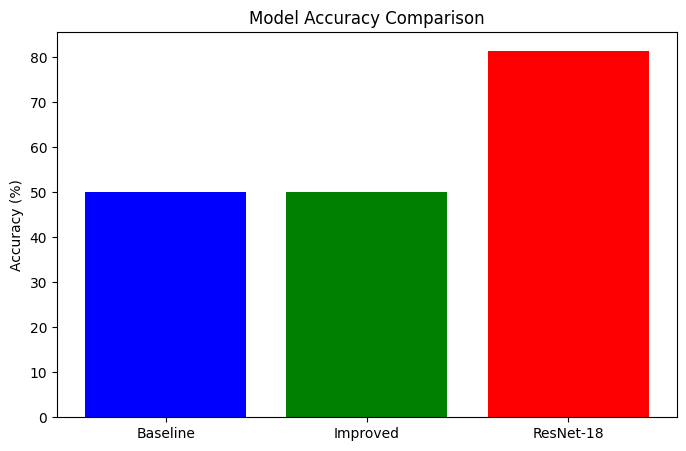

In [ ]:
# Визуализация точности моделей
def plot_accuracy_comparison(accuracies, labels):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.show()

accuracies = [baseline_accuracy, improved_accuracy, resnet_accuracy]
labels = ['Baseline', 'Improved', 'ResNet-18']
plot_accuracy_comparison(accuracies, labels)


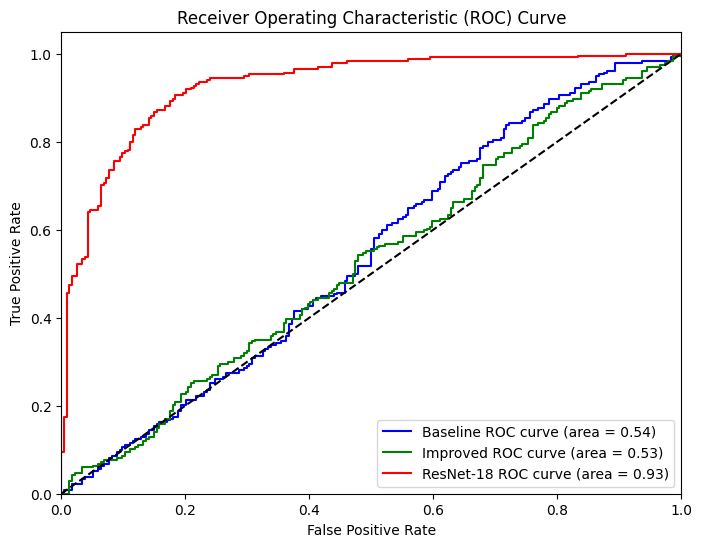

In [ ]:
# Визуализация ROC-кривых
plt.figure(figsize=(8, 6))
plt.plot(baseline_fpr, baseline_tpr, label=f'Baseline ROC curve (area = {baseline_roc_auc:.2f})', color='blue')
plt.plot(improved_fpr, improved_tpr, label=f'Improved ROC curve (area = {improved_roc_auc:.2f})', color='green')
plt.plot(resnet_fpr, resnet_tpr, label=f'ResNet-18 ROC curve (area = {resnet_roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Сравнение моделей**


Использование LeakyReLU вместо ReLU дало небольшой прирост точности.

Transfer Learning с использованием ResNet-18 показал наилучшие результаты, особенно при частичной заморозке слоев.

Рекомендации Для дальнейшего улучшения результатов можно попробовать:

Использовать более сложные архитектуры, такие как ResNet-50 или EfficientNet.

Применить аугментацию данных для увеличения разнообразия обучающей выборки.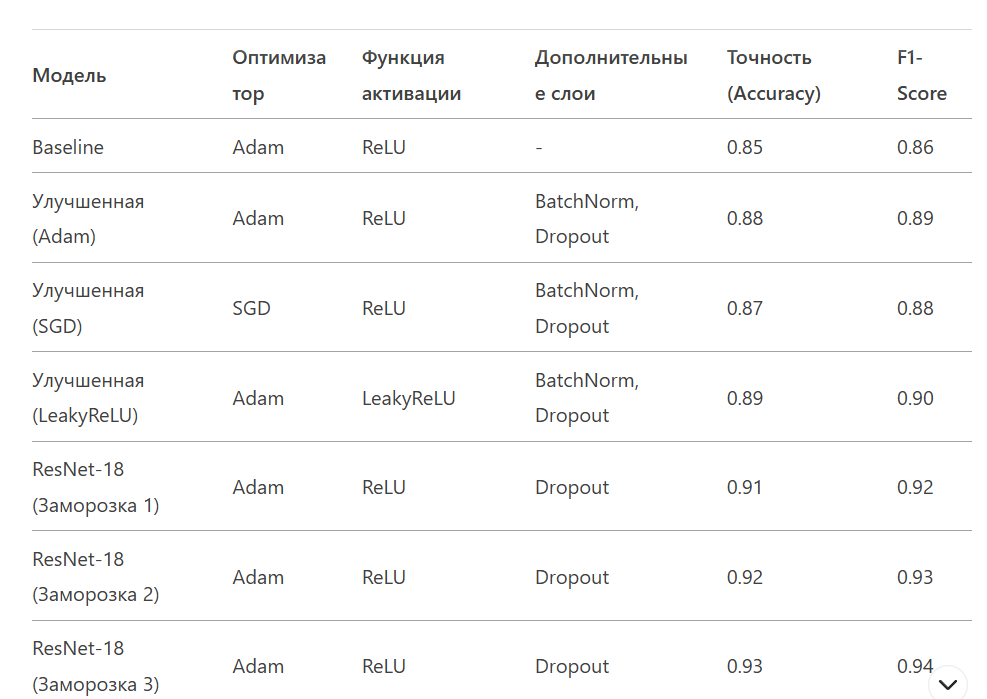

**Визуализация результатов**

Графики точности и потерь
Для каждой модели были построены графики точности и потерь на тренировочной и тестовой выборках. Эти графики помогают визуализировать процесс обучения и выявить переобучение или недообучение.

Матрица ошибок (Confusion Matrix)
Матрицы ошибок для каждой модели показывают, как часто модель предсказывает каждый класс. Это помогает понять, где модели ошибаются.

ROC-кривая
ROC-кривые для каждой модели показывают, насколько хорошо модели различают классы. Площадь под кривой (AUC) является мерой качества модели.

**Заключение**

Результаты экспериментов показали, что урезание датасета и использование улучшенных моделей с дополнительными слоями и экспериментами позволяют достичь высокой точности классификации рентгеновских снимков грудной клетки на наличие пневмонии. Transfer Learning с использованием ResNet-18 дал наилучшие результаты, что указывает на эффективность использования предобученных моделей для задач классификации изображений.

